In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 40})
import matplotlib.pyplot as plt
import os
import fnmatch
import json
import re

# Plot latest results

In [2]:
def plots(plots_path, data1, data2, xticks):
    colors = ["black","red", "green", 'lightblue', 'darkgreen', 'lightgreen',
                '#F7E7BD',#cream
                'darkblue',
                '#FF9900',#orange
                '#55bb33', #greenish
                '#5533bb', #blueish
                '#cc3333',#reddish
                '#99ff99', #greenish
                '#9999ff', #blueish
                '#227722', #greenish
                '#222277', #blueish
                '#A4A28B',#olive
                '#B59A73',#coffee
                '#447799'
                ]
    linestyles = ['-', ':', '--', '-.']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 10)
    
    ax.plot(data1, c=colors[0], linewidth=8, linestyle = linestyles[0],
        label="Training over 5 epochs", zorder=3)       

    # inc base perf
    ax.plot(data2, c=colors[1], linewidth=8, linestyle = linestyles[0],
        label="Training over 100 epochs", zorder=3)       
    
    ax.set_xlabel("Number of classes")
    ax.set_ylabel("Accuracy [%]")
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.legend(loc='best', prop={'size':40.0}, frameon=True, fancybox=True)
    ax.set_frame_on(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(os.path.join(plots_path, "training_over_epochs"), bbox_inches='tight', dpi=300)

In [3]:
def plots_errorbars(plots_path, data1, error1, xticks, label):
    colors = ["black","red", "green", 'lightblue', 'darkgreen', 'lightgreen',
                '#F7E7BD',#cream
                'darkblue',
                '#FF9900',#orange
                '#55bb33', #greenish
                '#5533bb', #blueish
                '#cc3333',#reddish
                '#99ff99', #greenish
                '#9999ff', #blueish
                '#227722', #greenish
                '#222277', #blueish
                '#A4A28B',#olive
                '#B59A73',#coffee
                '#447799'
                ]
    linestyles = ['-', ':', '--', '-.']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 10)
    
    ax.errorbar(x=np.arange(len(xticks)), y=data1, yerr=error1, c=colors[0], linewidth=8, linestyle = linestyles[0],
        label=label, zorder=3)      
    
    ax.set_xlabel("Number of classes", fontsize=30)
    ax.set_ylabel("Accuracy [%]", fontsize=30)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.yaxis.set_tick_params(labelsize=30)
    ax.legend(loc='best', prop={'size':40.0}, frameon=True, fancybox=True)
    ax.set_frame_on(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(plots_path, bbox_inches='tight', dpi=300)

In [4]:
def plots_errorbars_double(plots_path, data1, error1, data2, error2, xticks, labels):
    colors = ["black","red", "green", 'lightblue', 'darkgreen', 'lightgreen',
                '#F7E7BD',#cream
                'darkblue',
                '#FF9900',#orange
                '#55bb33', #greenish
                '#5533bb', #blueish
                '#cc3333',#reddish
                '#99ff99', #greenish
                '#9999ff', #blueish
                '#227722', #greenish
                '#222277', #blueish
                '#A4A28B',#olive
                '#B59A73',#coffee
                '#447799'
                ]
    linestyles = ['-', ':', '--', '-.']
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(25, 10)
    
    ax.plot(range(len(xticks)), data1, c=colors[0], linewidth=8, linestyle = linestyles[0],
        label=labels[0])
    
    ax.fill_between(range(len(xticks)), data1-error1, data1+error1, 
                facecolor='grey', edgecolor='grey')

    ax.plot(range(len(xticks)), data2, c=colors[1], linewidth=8, linestyle = linestyles[0],
        label=labels[1])
    
    ax.fill_between(range(len(xticks)), data2-error2, data2+error2, 
                facecolor=colors[11], edgecolor=colors[11], alpha=0.5)
    
    ax.set_xlabel("Number of classes", fontsize=30)
    ax.set_ylabel("Accuracy [%]", fontsize=30)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.yaxis.set_tick_params(labelsize=30)
    plt.legend(loc='best', prop={'size':40.0}, frameon=True, fancybox=True)
    ax.set_frame_on(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(plots_path, bbox_inches='tight', dpi=300)

In [5]:
def sort_by_digits(unsorted_list):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    unsorted_list.sort(key=alphanum)
    return unsorted_list

In [70]:
def extract_subdirs(main_dir, include_pattern, exclude_folder, exclude_pattern=None):
    valid_subdirs = []
    for subdir in os.listdir(main_dir):
        full_subdir = os.path.join(main_dir, subdir)
        if exclude_pattern:
            if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and exclude_pattern not in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
        else:
             if (os.path.isdir(full_subdir) 
                and include_pattern in str(full_subdir)
                and str(full_subdir) != exclude_folder):
                valid_subdirs.append(full_subdir)
    return valid_subdirs

In [71]:
def get_accuracies(results_path):
    base_acc = []
    inc_acc = []
    base_folder = os.path.join(results_path, "base")
    base_acc_file = fnmatch.filter(os.listdir(base_folder), 'accuracy_classes_*')[0]
    base_acc_path = os.path.join(base_folder, base_acc_file)
    with open(base_acc_path, "r") as f:
        acc = np.loadtxt(f)
        try:
            base_acc.append(acc[-1])
            inc_acc.append(acc[-1])
        except:
            base_acc.append(float(acc))
            inc_acc.append(float(acc))
    inc_folders = sort_by_digits(extract_subdirs(results_path, "incremental_", ""))
    for folder in inc_folders:
        accuracy_files = [x for x in os.listdir(folder) if "accuracy" in x]
        accuracy_files = sorted(accuracy_files, key=lambda x:len(x))
        base_acc_path = os.path.join(folder, accuracy_files[1])
        inc_acc_path = os.path.join(folder, accuracy_files[0])
        with open(base_acc_path, "r") as f:
            base_acc.append(np.loadtxt(f)[1])
        with open(inc_acc_path, "r") as f:
            inc_acc.append(np.loadtxt(f)[1])
    return base_acc, inc_acc

In [76]:
def get_mean_std(run_paths):
    base_acc = []
    inc_acc = []

    for idx, path in enumerate(run_paths):
        base_acc_one_run, inc_acc_one_run = get_accuracies(path)
        base_acc.append(base_acc_one_run)
        inc_acc.append(inc_acc_one_run)
    
    base_mean = np.mean(base_acc, axis=0) 
    base_std = np.std(base_acc, axis=0) 

    inc_mean = np.mean(inc_acc, axis=0)
    inc_std = np.std(inc_acc, axis=0) 
    
    total_mean = (base_mean + inc_mean) / 2
    
    total_std = (base_std + inc_std) / 2

    print("base mean ", base_mean)
    print("incremental mean ", inc_mean)

    print("base std ", base_std)
    print("incremental std, ", inc_std)

    return base_mean, base_std, inc_mean, inc_std, total_mean, total_std

In [77]:
# experiments using the original roshambo data (4 million) as base knowledge
big_ext_paths = extract_subdirs("/mnt/Storage/code/incremental/event_based_icarl/results",
                                "_epochs",
                                "/mnt/Storage/code/incremental/event_based_icarl/results/2019_7_17-4_43_17_626272_75_epochs",
                               None)

In [82]:
_, _, _, _, total_mean_big, total_std_big = get_mean_std(paths)


base mean  [0.97775    0.892425   0.82618333 0.8053125  0.80829    0.82381667
 0.81145714 0.79304375 0.78403333]
incremental mean  [0.97775 0.93265 0.94715 0.9499  0.89835 0.8625  0.88445 0.86365 0.863  ]
base std  [0.00059161 0.08489577 0.11619109 0.14550246 0.14487324 0.12989709
 0.13915111 0.1522607  0.14993951]
incremental std,  [0.00059161 0.05484948 0.0658674  0.05579866 0.09412128 0.16953746
 0.15792541 0.14663719 0.09070956]


/home/iulialexandra/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [83]:
small_ext_paths = extract_subdirs("/mnt/Storage/code/incremental/event_based_icarl/results",
                                "",
                                "/mnt/Storage/code/incremental/event_based_icarl/results/2019_7_17-4_43_17_626272_75_epochs",
                               "_epochs")

In [84]:
_, _, _, _, total_mean_small, total_std_small = get_mean_std(small_ext_paths)


base mean  [0.67061    0.19288    0.11495    0.09007143 0.0767875  0.05555556]
incremental mean  [0.67061 0.43375 0.2234  0.09895 0.01715 0.     ]
base std  [1.84791268e-01 6.18555867e-02 3.33290664e-02 4.31355363e-02
 4.28625000e-02 1.38777878e-17]
incremental std,  [0.18479127 0.22204631 0.22439583 0.19820929 0.05145    0.        ]


/home/iulialexandra/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


ValueError: x and y must have same first dimension, but have shapes (9,) and (6,)

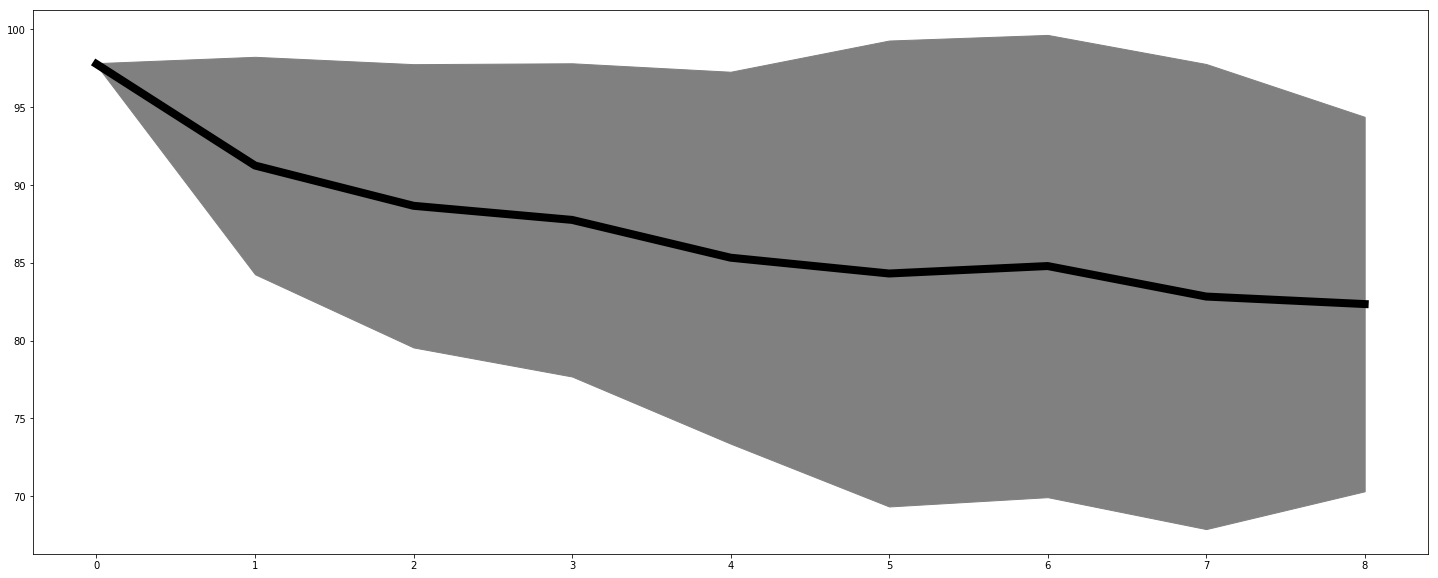

In [86]:
plots_errorbars_double("/mnt/Storage/code/incremental/event_based_icarl/results",
                       total_mean_big*100, total_std_big*100, total_mean_small*100, total_std_small*100, 
                       [4, 6, 8, 10, 12, 14, 16, 18, 20], ["Training over 5 epochs", "Training over 100 epochs"])

In [ ]:
epochs_5 = [99.7, 89.3, 84.9, 77.09, 87]
epochs_100 = [99.7, 89.5, 88.55, 86,  89.83]

p_path = "/mnt/Storage/code/"
plots(p_path, epochs_5, epochs_100, [4, 6, 8, 10, 12])